Day4　ver1.0

・自己回帰モデルにおいてコレログラムを描画しLagについて検討  
・線形回帰モデル、RANSAC、SVRを適用するにあたって、搬送者数を出力として用いる  
・疎構造モデルを試してみる

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
#from pandas.plotting import scatter_matrix

import statsmodels.api as sm  #ARMAで予測する際に用いるライブラリ
from scipy.ndimage.interpolation import shift  #numpyの配列をshiftするための関数
import scipy

from sklearn.linear_model import LinearRegression

%matplotlib inline

# data

In [2]:
# all pref 2016
df2016 = pd.read_excel('data/hot/zenkoku2016.xlsx', sheet_name='Sheet1')

ta = df2016["temp"]
ws = df2016["wind_speed"]
sr = df2016["solar_radiation"]
rh = df2016["relative_humidity"]

wbgt = []
wbgt = 0.735 * ta + 0.0374 * rh + 0.00292 * ta * rh + 7.619 * sr - 4.557 * sr**2 - 0.0572 * ws - 4.064
wbgt = pd.DataFrame(wbgt, columns=["wbgt"])
df6w = pd.concat([df2016, wbgt], axis=1)  # 4data + wbgt

# lack of data
# display(df6w.isnull().sum())

# drop
df6w.dropna(inplace=True)

wbgt6 = df6w["wbgt"].values  # wbgt value
df6wt = df6w[df6w['place'] == 'tokyo']  # tokyo
df6wn = df6w[df6w['place'] == 'nagoya']  # nagoya
df6wo = df6w[df6w['place'] == 'osaka']  # osaka


# New Data
#  to hospital at tokyo,nagoya,osaka 2016
h2016 = pd.read_excel('data/hot/hansou_2016_tno.xlsx', sheet_name='2016')

h2016t = h2016[h2016['place'] == 'tokyo']
h2016o = h2016[h2016['place'] == 'osaka']
h2016n = h2016[h2016['place'] == 'aichi'] # aichi = nagoya

N6t, N6n, N6o = len(df6wt), len(df6wn), len(df6wo)
N6ht, N6hn, N6ho = len(h2016t), len(h2016n), len(h2016o)

# print("2016 climate data number : ",N6t,N6n,N6o)
# print("2016 to hospital data number :",N6ht,N6ha,N6ho)

# print()
# print("all")
# display(df6w.describe())
# print('tokyo')
# display(df6wt.describe())
# display(h2016t.describe())
# print('nagoya')
# display(df6wn.describe())
# display(h2016a.describe())
# print('osaka')
# display(df6wo.describe())
# display(h2016o.describe())


# all pref 2017
df2017 = pd.read_excel('data/hot/zenkoku2017.xlsx', sheet_name='Sheet1')

ta = df2017["temp"]
ws = df2017["wind_speed"]
sr = df2017["solar_radiation"]
rh = df2017["relative_humidity"]

wbgt = []
wbgt = 0.735 * ta + 0.0374 * rh + 0.00292 * ta * rh + 7.619 * sr - 4.557 * sr**2 - 0.0572 * ws - 4.064
wbgt = pd.DataFrame(wbgt, columns=["wbgt"])

df7w = pd.concat([df2017, wbgt], axis=1)  # 4data + wbgt

#  lack of data
# display(df7w.isnull().sum())

# drop
df7w.dropna(inplace=True)

wbgt7 = df7w["wbgt"].values # wbgt value
df7wt = df7w[df7w['place'] == 'tokyo'] # tokyo
df7wn = df7w[df7w['place'] == 'nagoya'] # nagoya
df7wo = df7w[df7w['place'] == 'osaka'] # osaka


# New Data
#  to hospital at tokyo,nagoya,osaka　
h2017 = pd.read_excel('data/hot/hansou_2017_tno.xlsx', sheet_name='2017')

h2017t = h2017[h2017['place'] == 'tokyo']
h2017o = h2017[h2017['place'] == 'osaka']
h2017n = h2017[h2017['place'] == 'aichi'] # aichi = nagoya

N7t, N7n, N7o = len(df7wt), len(df7wn), len(df7wo)
N7ht, N7hn, N7ho = len(h2017t), len(h2017n), len(h2017o)


# all pref 2018
df2018 = pd.read_excel('data/hot/zenkoku2018.xlsx', sheet_name='Sheet1')

ta = df2018["temp"]
ws = df2018["wind_speed"]
sr = df2018["solar_radiation"]
rh = df2018["relative_humidity"]

wbgt = []
wbgt = 0.735 * ta + 0.0374 * rh + 0.00292 * ta * rh + 7.619 * sr - 4.557 * sr**2 - 0.0572 * ws - 4.064
wbgt = pd.DataFrame(wbgt, columns=["wbgt"])

df8w = pd.concat([df2018, wbgt], axis=1)  # 4data + wbgt

#  lack of data
# display(df7w.isnull().sum())

# drop
df8w.dropna(inplace=True)

wbgt8 = df8w["wbgt"].values # wbgt value
df8wt = df8w[df8w['place'] == 'tokyo'] # tokyo
df8wn = df8w[df8w['place'] == 'nagoya'] # nagoya
df8wo = df8w[df8w['place'] == 'osaka'] # osaka


# New Data
#  to hospital at tokyo,nagoya,osaka
h2018 = pd.read_excel('data/hot/hansou_2018_tno.xlsx', sheet_name='2018')

h2018t = h2018[h2018['place'] == 'tokyo']
h2018o = h2018[h2018['place'] == 'osaka']
h2018n = h2018[h2018['place'] == 'aichi'] # aichi = nagoya

N8t, N8n, N8o = len(df8wt), len(df8wn), len(df8wo)
N8ht, N8hn, N8ho = len(h2018t), len(h2018n), len(h2018o)

# AR

In [3]:
temp6n = df6wn.temp
temp6n.head()

37536    23.8
37537    23.5
37538    23.2
37539    22.7
37540    22.8
Name: temp, dtype: float64

In [4]:
ar = sm.tsa.AR(temp6n)
model_ar = ar.fit(maxlag=24 ,method='cmle',forecasting.)

/Users/peasucrivafie/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [5]:
maxlag = 24 #24Hr/day

df = pd.DataFrame(temp6n, columns={"temp"})

for lag in range(1,maxlag+1):
    df["x%s"%lag] = df["temp"].shift(lag)
df.head(24)

,temp,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24
37536,23.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37537,23.5,23.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37538,23.2,23.5,23.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37539,22.7,23.2,23.5,23.8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37540,22.8,22.7,23.2,23.5,23.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37541,23.3,22.8,22.7,23.2,23.5,23.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37542,24.8,23.3,22.8,22.7,23.2,23.5,23.8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37543,27.0,24.8,23.3,22.8,22.7,23.2,23.5,23.8,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37544,28.2,27.0,24.8,23.3,22.8,22.7,23.2,23.5,23.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37545,28.1,28.2,27.0,24.8,23.3,22.8,22.7,23.2,23.5,23.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# 欠損値の除去
df.dropna(inplace=True)

In [7]:
# 学習データを予測させる
y_pred = ar.predict(model_ar.params)
df["y_pred"] = y_pred
df["error"] = (df["temp"] - df["y_pred"])**2  #　誤差の2乗

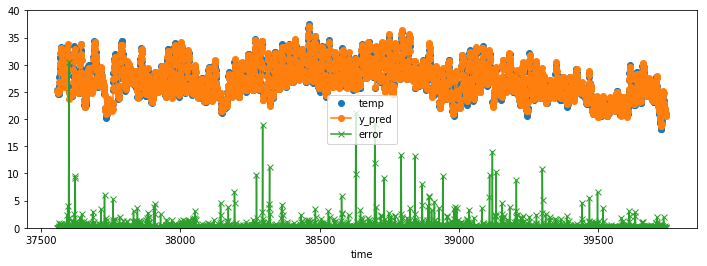

In [8]:
plt.figure(figsize=(12, 4))
df["temp"].plot(marker="o", ls="")
df["y_pred"].plot(marker="o", ls="-")
df["error"].plot(marker="x", ls="-")
plt.ylim([0, 40])
plt.xlabel("time")
plt.legend(["temp", "y_pred", "error"])

In [9]:
# 自己相関
#
# statsmodels.tsa.stattools.acf
# (x, unbiased=False, nlags=40, qstat=False, fft=None, 
# alpha=None, missing='none')
#
# nlags (int, optional) – Number of lags to return autocorrelation for.
#
# Autocorrelation function for 1d arrays.

ts_acf = sm.tsa.stattools.acf(temp6n,nlags = 24)
ts_acf

array([1.        , 0.96129987, 0.89198795, 0.79610907, 0.68306194,
       0.56255108, 0.44285201, 0.33044029, 0.23263688, 0.15227733,
       0.09299874, 0.0551309 , 0.03714415, 0.04012497, 0.0637557 ,
       0.10781446, 0.17111281, 0.25168953, 0.34292524, 0.43923455,
       0.53340053, 0.62033469, 0.68773978, 0.72868461, 0.73778068])

In [10]:
ts_pacf = sm.tsa.stattools.pacf(temp6n,nlags=24,method='ols')
ts_pacf

array([ 1.        ,  0.96285684, -0.43334154, -0.28202465, -0.1178844 ,
       -0.01415759,  0.0207984 ,  0.02740823,  0.06808529,  0.04049184,
        0.07009581,  0.03736719,  0.03333087,  0.09279625,  0.1180488 ,
        0.14422558,  0.16179861,  0.1720752 ,  0.11671982,  0.10234424,
        0.08108645,  0.10311847, -0.04603269, -0.08038661, -0.10729909])

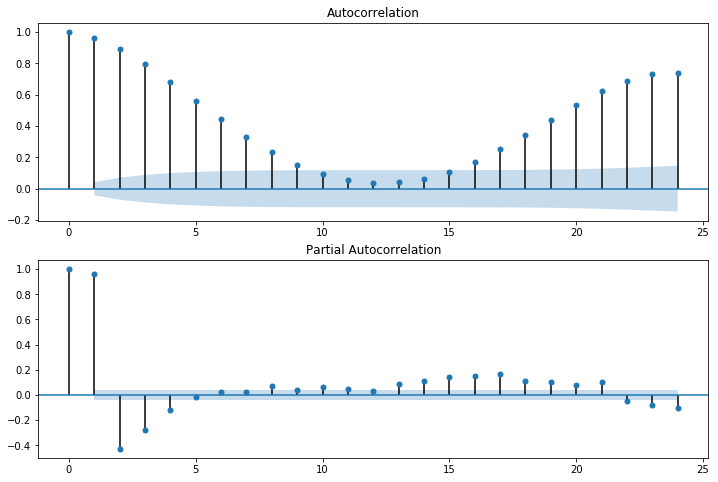

In [11]:
#  自己相関のグラフ
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp6n, lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp6n, lags=24, ax=ax2)

自己相関係数は、３時間以下、の方が、　２４時間、よりも大きいという結果

# to hospital

## 搬送者数の推移

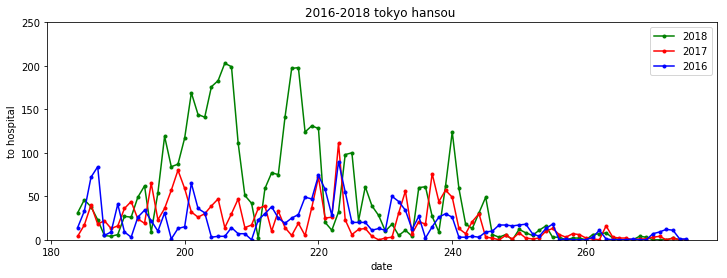

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(h2018t.hansou,marker=".", ls="-",color='g',label='2018')
plt.plot(h2017t.hansou,marker=".", ls="-",color='r',label='2017')
plt.plot(h2016t.hansou,marker=".", ls="-",color='b',label='2016')
plt.ylim([0,250])
plt.legend()
plt.xlabel('date')
plt.ylabel('to hospital')
plt.title('2016-2018 tokyo hansou ')
plt.show()

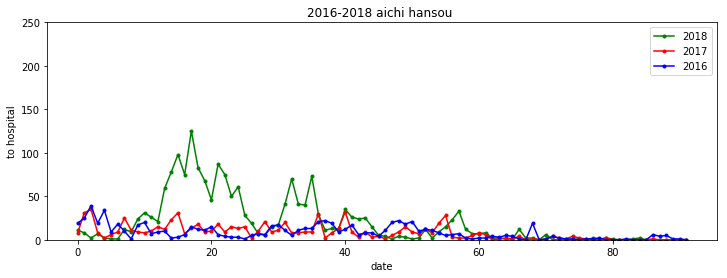

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(h2018n.hansou,marker=".", ls="-",color='g',label='2018')
plt.plot(h2017n.hansou,marker=".", ls="-",color='r',label='2017')
plt.plot(h2016n.hansou,marker=".", ls="-",color='b',label='2016')
plt.ylim([0,250])
plt.legend()
plt.xlabel('date')
plt.ylabel('to hospital')
plt.title('2016-2018 aichi hansou ')
plt.show()

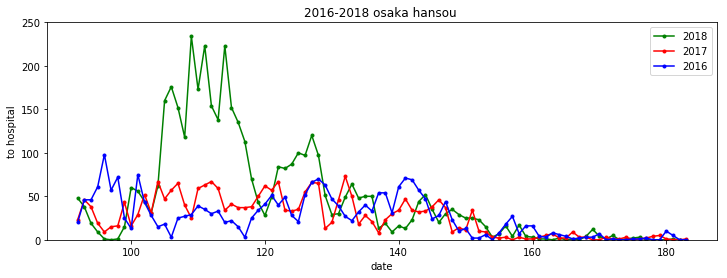

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(h2018o.hansou,marker=".", ls="-",color='g',label='2018')
plt.plot(h2017o.hansou,marker=".", ls="-",color='r',label='2017')
plt.plot(h2016o.hansou,marker=".", ls="-",color='b',label='2016')
plt.ylim([0,250])
plt.legend()
plt.xlabel('date')
plt.ylabel('to hospital')
plt.title('2016-2018 osaka hansou ')
plt.show()

## 搬送者数と計測データとの関係

<Figure size 216x216 with 0 Axes>

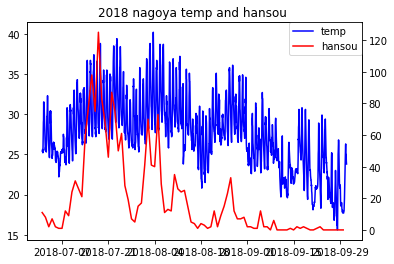

In [15]:
fig = plt.figure(figsize=(3,3))
fig, ax1 = plt.subplots()
 
ax2 = ax1.twinx()
 
ax1.plot(df8wn.time,df8wn.temp,'b-')
ax2.plot(h2018n.date,h2018n.hansou,'r-')

handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()

plt.title('2018 nagoya temp and hansou ')

ax1.legend(handler1 + handler2, label1 + label2, loc=1, borderaxespad=0.)

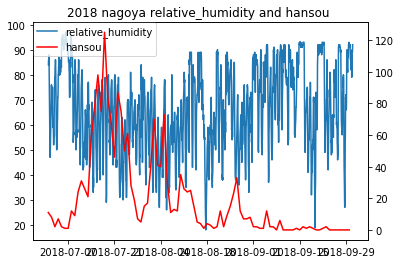

In [16]:
fig, ax1 = plt.subplots()
 
ax2 = ax1.twinx()
 
ax1.plot(df8wn.time,df8wn.relative_humidity)
ax2.plot(h2018n.date,h2018n.hansou,'r-')
 
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()

plt.title('2018 nagoya relative_humidity and hansou ')

ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

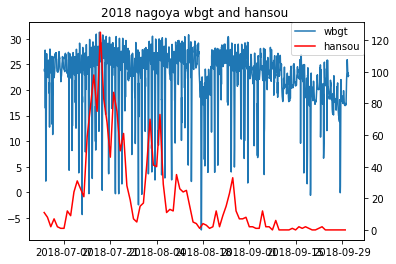

In [17]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(df8wn.time, df8wn.wbgt)
ax2.plot(h2018n.date, h2018n.hansou, 'r-')

handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()

plt.title('2018 nagoya wbgt and hansou ')

ax1.legend(handler1 + handler2, label1 + label2, loc=1, borderaxespad=0.)

# Linear Regression

In [18]:
import pandas as pd
import numpy as np
from datetime import datetime as dt

In [19]:
df6wn_1=df6wn.loc[:, ["temp"]]

In [20]:
df6wn_2= pd.to_datetime(df6wn['time'], errors='coerce')

In [21]:
df6wn_3 = df6wn_1.groupby(df6wn_2.dt.date)['temp'].max()

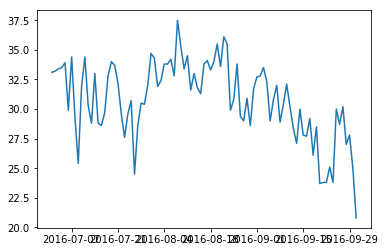

In [22]:
plt.plot(df6wn_3)

coef :  [1.78393221] intercept :  -46.716


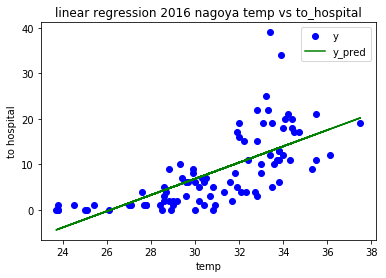

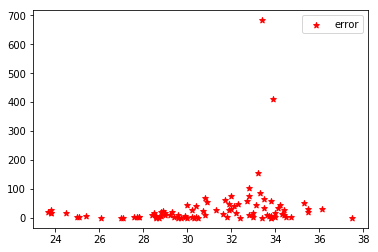

In [23]:
x=df6wn_3[0:92].values
y= h2016n.hansou.values

X = x.reshape(-1,1)
reg = LinearRegression()
reg.fit(X, y)
print("coef : ", reg.coef_, "intercept : ", reg.intercept_.round(3))

y_pred = reg.predict(X)
error = (y - y_pred)**2

plt.plot(x, y, 'bo')
plt.plot(x, y_pred, marker='', ls="-",c='g')

plt.legend(["y", "y_pred"])
plt.xlabel("temp")
plt.ylabel("to hospital")
plt.title("linear regression 2016 nagoya temp vs to_hospital")

plt.show()

plt.scatter(x, error, marker="*",c="r")

plt.legend(["error"])
plt.show()

In [24]:
error[error.argsort(axis=0)[::-1][:3]]

array([682.89074725, 409.66619318, 155.97424251])

線形回帰で予測した場合、上記の誤差過大データを異常と判断することは可能

# RANSAC

RANSAC (RANdom SAmple Consensus) fits a model from random subsets of inliers from the complete data set.

RANSAC is a non-deterministic algorithm producing only a reasonable result with a certain probability, which is dependent on the number of iterations (see max_trials parameter). It is typically used for linear and non-linear regression problems and is especially popular in the fields of photogrammetric computer vision.

The algorithm splits the complete input sample data into a set of inliers, which may be subject to noise, and outliers, which are e.g. caused by erroneous measurements or invalid hypotheses about the data. The resulting model is then estimated only from the determined inliers.

In [25]:
from sklearn.linear_model import LinearRegression,RANSACRegressor
ransac = RANSACRegressor(LinearRegression())

In [26]:
X = x.reshape(-1,1)
ransac.fit(X,y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=None, random_state=None,
        residual_metric=None, residual_threshold=None, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

In [27]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)#反転
outlier_mask

array([ True,  True,  True,  True,  True, False,  True,  True, False,
        True,  True, False, False, False, False, False, False,  True,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False,  True,  True,
        True,  True,  True, False, False,  True, False, False, False,
       False, False,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

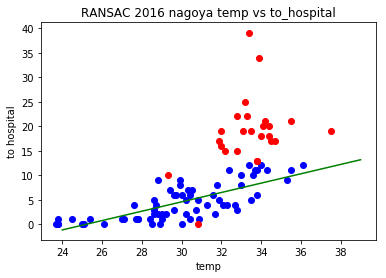

In [28]:
line_X = np.arange(24,40,1)
line_Y = ransac.predict(line_X[:,np.newaxis])
plt.scatter(X[inlier_mask],y[inlier_mask],c="blue",marker="o",label="Intliers")#正常値
plt.scatter(X[outlier_mask],y[outlier_mask],c="red",marker="o",label="Outliers")#外れ値
plt.plot(line_X,line_Y,color="green")#予測値

plt.xlabel("temp")
plt.ylabel("to hospital")
plt.title("RANSAC 2016 nagoya temp vs to_hospital")
plt.show()

線形回帰より外れ値の影響を受けにくい

# Support Vector Regression

In [29]:
from sklearn.svm import SVR

In [30]:
X = x.reshape(-1,1)
svr_lin = SVR(kernel='linear', C=10)
svr_rbf1 = SVR(kernel='rbf', C=10, gamma=1)
svr_rbf2 = SVR(kernel='rbf', C=100, gamma=0.01)
y_lin = svr_lin.fit(X, y).predict(X)
y_rbf1 = svr_rbf1.fit(X, y).predict(X)
y_rbf2 = svr_rbf2.fit(X, y).predict(X)

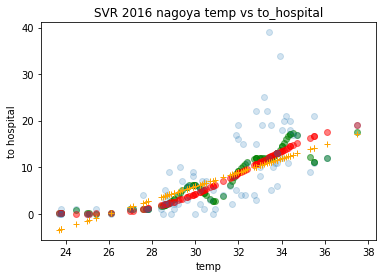

In [31]:
# 学習結果の描画
plt.plot(x, y, 'o', alpha=0.2)
plt.plot(x, y_lin, '+', c="orange")
#plt.plot(x, y_rbf1, c="g")
#plt.plot(x, y_rbf2, c="r")
plt.scatter(x, y_rbf1, c="g",alpha=0.5)
plt.scatter(x, y_rbf2, c="r",alpha=0.5)

plt.xlabel("temp")
plt.ylabel("to hospital")
plt.title("SVR 2016 nagoya temp vs to_hospital")
plt.xlabel("temp")
plt.ylabel("to hospital")
plt.show()

ハイパーパラメータを適切に設定する必要がある

# 疎構造

北海道から沖縄まで距離が離れた地点の気温データの相関を確認してみる

In [32]:
from sklearn.covariance import GraphLasso
from sklearn.preprocessing import StandardScaler

In [33]:
t_tko=df6wt['temp'].values
t_ngo=df6wn['temp'].values
t_osk=df6wo['temp'].values

t_sap=df2016[df2016['place']=='sapporo']['temp'].values
t_nha=df2016[df2016['place']=='naha']['temp'].values
t_fuk=df2016[df2016['place']=='fukuoka']['temp'].values
t_kof=df2016[df2016['place']=='kofu']['temp'].values

In [34]:
t = pd.DataFrame(
    [t_sap, t_tko, t_kof, t_ngo, t_osk, t_fuk, t_nha],
    index=['sapporo', 'tokyo', 'kofu', 'nagoya', 'osaka', 'fukuoka', 'naha'])

In [35]:
t

,0,1,2,3,4,5,6,7,8,9,...,2198,2199,2200,2201,2202,2203,2204,2205,2206,2207
sapporo,18.4,18.3,18.2,18.1,18.2,19.2,20.9,22.7,24.3,25.1,...,21.7,21.1,19.6,18.9,18.2,18.0,16.7,16.2,16.7,16.2
tokyo,22.6,22.3,22.3,22.7,22.7,23.2,24.2,24.8,25.6,26.1,...,23.3,22.7,22.1,21.9,21.5,21.3,22.0,21.5,21.8,21.5
kofu,22.6,22.9,22.5,22.4,22.4,22.7,23.3,24.6,26.2,28.7,...,23.5,22.6,21.6,20.9,20.6,20.3,20.1,20.0,19.8,19.5
nagoya,23.8,23.5,23.2,22.7,22.8,23.3,24.8,27.0,28.2,28.1,...,23.4,23.4,22.6,22.1,21.9,21.1,21.0,20.7,20.9,20.8
osaka,24.4,24.4,24.1,24.0,24.0,23.7,25.1,25.5,27.1,28.4,...,26.3,26.3,26.3,25.3,24.3,22.6,21.7,21.8,21.8,21.8
fukuoka,24.3,24.3,24.4,23.9,23.9,24.2,25.6,27.2,28.1,28.7,...,26.9,25.5,25.7,25.4,22.8,22.3,22.3,22.4,22.1,22.6
naha,28.6,28.4,28.2,28.1,28.1,28.1,28.9,29.9,30.9,31.5,...,31.4,30.8,29.9,29.1,28.9,28.9,28.2,28.3,28.3,28.1


In [36]:
X=t.T

# 標準化
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

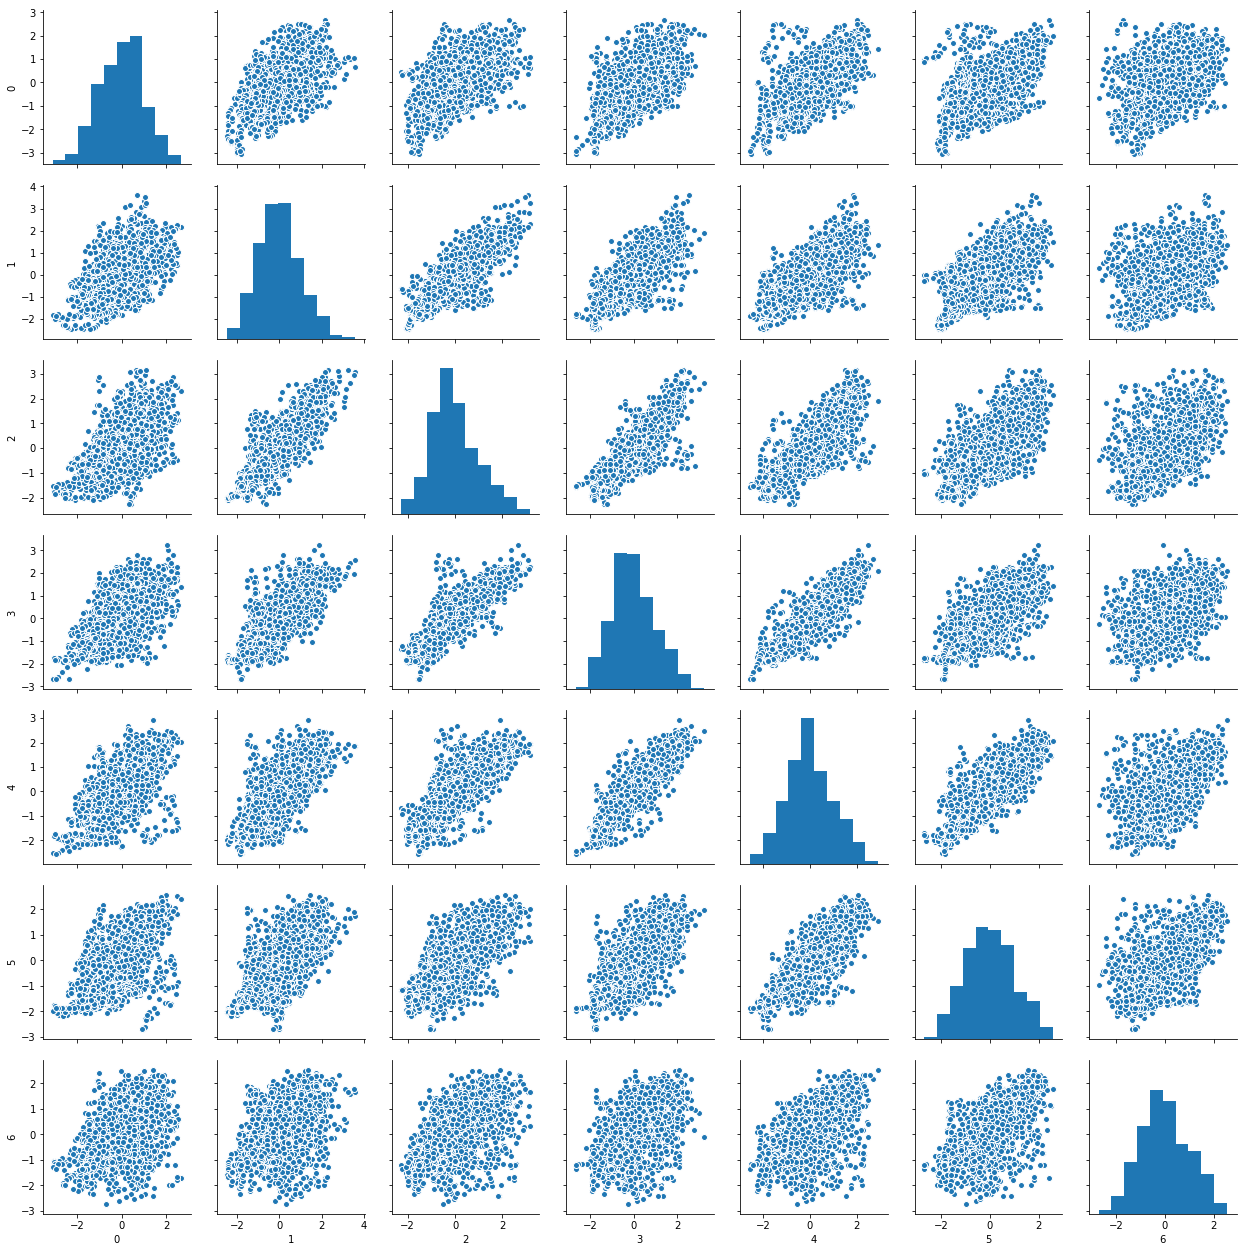

In [37]:
sns.pairplot(pd.DataFrame(X))

距離が近い拠点同士は相関が強いように見える

In [38]:
cov = np.corrcoef(X)

In [39]:
# parametars
alpha = 0.2 # L１正則化パラメーター

M = X.shape[1]
label = ["x{}".format(i + 1) for i in range(M)]

In [40]:
model = GraphLasso(
    alpha=alpha, max_iter=100, verbose=True, assume_centered=True)
model.fit(X)
cov_ = model.covariance_  # 分散共分散行列
prec_ = model.precision_  # 精度行列

[graph_lasso] Iteration   0, cost  3.00e+01, dual gap 3.073e-01
[graph_lasso] Iteration   1, cost  2.99e+01, dual gap 1.688e-05


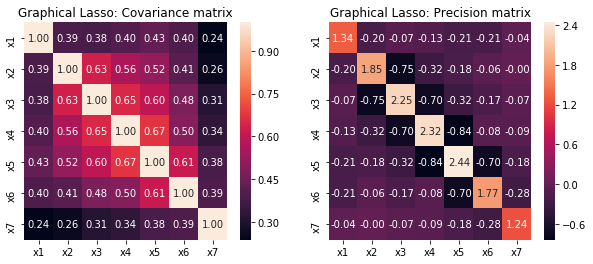

In [41]:
# Scikit LearnのGraphical Lassoの結果表示
plt.figure(figsize=(10, 4))
ax = plt.subplot(121)
sns.heatmap(
    cov_, annot=cov_, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
plt.title("Graphical Lasso: Covariance matrix")

ax = plt.subplot(122)
sns.heatmap(
    prec_,
    annot=prec_,
    fmt='0.2f',
    ax=ax,
    xticklabels=label,
    yticklabels=label)
plt.title("Graphical Lasso: Precision matrix")
plt.show()

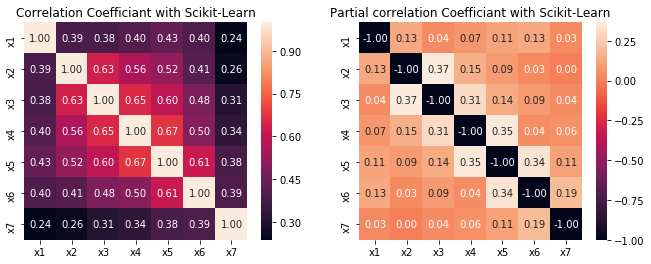

In [42]:
# 相関行列の算出
cor = np.empty_like(cov_)
for i in range(M):
    for j in range(M):
        cor[i, j] = cov_[i, j] / np.sqrt(cov_[i, i] * cov_[j, j])

# 偏相関行列の算出
rho = np.empty_like(prec_)
for i in range(M):
    for j in range(M):
        rho[i, j] = -prec_[i, j] / np.sqrt(prec_[i, i] * prec_[j, j])

plt.figure(figsize=(11, 4))
ax = plt.subplot(122)
sns.heatmap(
    pd.DataFrame(rho),
    annot=rho,
    fmt='0.2f',
    ax=ax,
    xticklabels=label,
    yticklabels=label)
plt.title("Partial correlation Coefficiant with Scikit-Learn")

ax = plt.subplot(121)
sns.heatmap(
    pd.DataFrame(cor),
    annot=cor,
    fmt='0.2f',
    ax=ax,
    xticklabels=label,
    yticklabels=label)
plt.title("Correlation Coefficiant with Scikit-Learn")
plt.show()

偏相関行列値が小さくなり間接相関の効果を除去できているように見受けられる  
異常検知問題として、  
1外れ値検出、2分布変化検知、3構造変化検知  
にも取り組む予定　　

# ガウス過程

対応予定